In [2]:
import numpy as np
from numpy.linalg import inv # for matrix inverse on np.array objects, equals to np.matrix.I
import matplotlib.pyplot as plt
import scipy.signal as sps # for autocorrelation calculation

In [3]:
############### Parameters, variables and methods #########################

In [4]:
# covariance of the stochastic gradient noise, V in the paper
covSGN = 1

# covariance matrix
rho = 0.9
# np.array object, not the subclass--np.matix (specialized 2-D array), so * is not permitted for matrix multiplication later
covM = np.array([[1,rho],[rho,1]]) 
invM = inv(covM)
# inverse covariance matrix, still np.array object
# invM = array([[ 5.26315789, -4.73684211],
#               [-4.73684211,5.26315789]])

# intial position in 2D format, x = [0;0] in matlab, which means a size(2,1) matrix 
theta = np.array([[0],[0]]) 

# dimension of the position theta, here is 2 for bivariate Gaussian
dimT = len(theta)

# this is highest learning rate value tried so far for SGLD that does not diverge
etaSGLD = 0.15
etaSGHMC = 0.05
alpha = 0.05
'''
In matlabetaSGLD = 0.18
'''

# number of different settings for the initial step size
nSet = 5

# gradUNoise for function as follows:

funcU = lambda x = None: 0.5 * np.dot(np.dot(np.transpose(x), invM), x) 
gradUTrue = lambda x = None: np.dot(invM, x)
gradUNoise = lambda x = None: np.dot(invM, x) + np.random.randn(2,1)

# initial variables for the MAE and AucTime
aucT = np.zeros(dimT)

covESGLD = np.zeros((dimT, dimT, nSet))
meanESGLD = np.zeros((dimT, nSet))
SGLDCovErr = np.zeros(nSet) 
SGLDeta = np.zeros(nSet)
SGLDauc = np.zeros(nSet)

covESGHMC = np.zeros((dimT, dimT, nSet))
meanESGHMC = np.zeros((dimT, nSet))
SGHMCCovErr = np.zeros(nSet)
SGHMCeta = np.zeros(nSet)
SGHMCauc = np.zeros(nSet)

# set random seed
np.random.seed(20)

# number of steps for producing 10 million samples
nStep = 10000000


In [5]:
## auto correlation time, the calculation method comes from Hoffman et.al. No-U-Turn sampeler
def aucTime(samples = None, samVar = None): 
    
    # for every dimension
    for i in range(dimT):
        
        # reproduce xcorr in matlab, acorr 1D array with len=2L+1
        # in matlab, xcorr does the biased estimate of the cross-correlation
        # in matlab, xcorr will pad 0 at the beginning and the last of the returned matrix
        
        acorr = sps.correlate(samples[i,:],samples[i,:], mode='full') / nStep / samVar
        acorr = np.insert(acorr,0,0) # pad 0 at the beginning
        acorr = np.append(acorr,0)   # pad 0 at the last
        
        '''
        I used np.correlate at the beginning, it becomes really slow when samples comes to 10 million, 
        like 1 hour or more to do the correlation here.
        That is, numpy.correlate may perform slowly in large arrays (i.e. n = 1e5) 
        because it does not use the FFT to compute the convolution; 
        in that case, scipy.signal.correlate might be preferable.
        
        ''' 
        
        res = 1
        # for every sample
        for j in range(nStep):
            rpho = 0.5 * (acorr[nStep + j] + acorr[nStep - j])
            if rpho < 0.05:
                break
            res = res + 2 * (1 - j / nStep)
        aucT[i] = res
    
    return aucT

In [6]:
## SGLD using gradUNoise, for nStep steps, starting at position theta, use SGFS way to take noise gradient level into account,
## return data: array of positions

def sgld(gradU = None, eta = None, nStep = None, theta = None, covSGN = None): 
    
    # record the samples, the positions/theta
    samples = np.zeros((dimT, nStep))
    
    # diffusion matrix contributed by gradient noise, true stochastic gradient noise
    beta = covSGN * eta * 0.5 
    
    if beta > 1:
        raise Exception('too big eta')
    
    sigma = np.sqrt(2 * eta * (1 - beta))
    
    # do leapfrog
    for i in range(nStep):
        dtheta = - gradU(theta) * eta + np.random.randn(2,1) * sigma
        theta = theta + dtheta  # theta shape: 2D (2,1)
        samples[:,[i]] = theta
        
    return samples


In [7]:
## SGHMC using gradUNoise, for nStep steps, starting at position theta
## return data: array of positions

def sghmc(gradU = None,eta = None, nStep = None, alpha = None, theta = None, covSGN = None): 
    
    # record the samples, the positions/theta
    samples = np.zeros((dimT, nStep))
    
    # diffusion matrix contributed by gradient noise, true stochastic gradient noise
    beta = covSGN * eta * 0.5 
    
    if beta > alpha:
        raise Exception('too big eta')
    
    sigma = np.sqrt(2 * eta * (alpha - beta))
    r = np.random.randn(dimT, 1) * np.sqrt(eta)
    momentum = 1 - alpha
    
    # do leapfrog
    for i in range(nStep):
        r = r * momentum - gradU(theta) * eta + np.random.randn(2,1) * sigma
        theta = theta + r
        samples[:,[i]] = theta

    return samples

In [8]:
print('The number of samples is: ', nStep)
print('The initial etaSGLD is: ', etaSGLD)
print('The linearly decreasing scale of etaSGLD is: 0.8')

for i in range(nSet): 
    
    print('\nSGLD Set ' + str(i) + ' begins: ')
    
    # *************************************************for SGLD********************************** #
    
    # initial learning rate/step size on a linearly decreasing scale for 5 different settings
    eta = etaSGLD * (0.8 ** (i - 1)) 
    
    # produce samples using SGLD with shape (dimT, nStep)=(2,10000000)
    # use gradUNoise for SGLD and change eta for each step
    dsgld = sgld(gradUNoise, eta, nStep, theta, covSGN) 
    
    # calculate Sample Covariance
    covESGLD[:,:,i] = np.dot(dsgld, np.transpose(dsgld)) / nStep 
    
    # calculate the mean of each row/dim of all thetas
    meanESGLD[:,i] = np.mean(dsgld, axis=1)
    
    # calculate Average Absolute Error of Sample Covariance of the samples 
    SGLDCovErr[i] = np.sum(np.sum(np.abs(covESGLD[:,:,i] - np.dot(meanESGLD[:,[i]], np.transpose(meanESGLD[:,[i]])) - covM))) / 4
    
    '''
    
    meanESGLD[:,[i]] in python = meanESGLD(:,i) in matlab, both generating 2D matrix here.
    
    Here, in matlab, meanESGLD(:,i) is a 2D matrix with size (dimT,1).
    However, meanESGLD[:,i] means 1D array in python which has the lenth of dimT.
    If we use np.matmul(meanESGLD[:,i],meanESGLD[:,i].T), then we will get a 1D array.
    And covESGLD[:,:,i] is a 2D array with size (dimT,dimT)
    Also, 2D array - 1D array can be calculated in python.
    For example, np.array([[1,2],[3,4]])-np.array([0.5,0.3]),
    the result is:
    array([[0.5, 1.7],
       [2.5, 3.7]])
    Therefore, meanESGLD[:,i] should not be used here.
    
    '''
    
    # calculate Autocorrelation Time
    SGLDeta[i] = eta
    SGLDauc[i] = np.mean(aucTime(dsgld,1))
    
    print('\nSGLDAucTime for Set ' + str(i) + ' is: ' + str(SGLDauc[i]) )
    print('SGLDCovErr for Set ' + str(i) + ' is: ' + str(SGLDCovErr[i]))


The number of samples is:  10000000
The initial etaSGLD is:  0.15
The linearly decreasing scale of etaSGLD is: 0.8

SGLD Set 0 begins: 

SGLDAucTime for Set 0 is: 50.99994000000001
SGLDCovErr for Set 0 is: 0.7506056557531001

SGLD Set 1 begins: 

SGLDAucTime for Set 1 is: 74.99986680000002
SGLDCovErr for Set 1 is: 0.15002057607494623

SGLD Set 2 begins: 

SGLDAucTime for Set 2 is: 92.99979300000001
SGLDCovErr for Set 2 is: 0.07500488500622304

SGLD Set 3 begins: 

SGLDAucTime for Set 3 is: 115.99967510000002
SGLDCovErr for Set 3 is: 0.04619452509565214

SGLD Set 4 begins: 

SGLDAucTime for Set 4 is: 144.99948880000002
SGLDCovErr for Set 4 is: 0.031212264270422785


In [9]:
print('The number of samples is: ', nStep)
print('The initial etaSGHMC is: ', etaSGHMC)
print('The momentum alphaSGHMC is: ', alpha)
print('The linearly decreasing scale of etaSGHMC and alphaSGHMC is: 0.6')

for i in range(nSet):   
    print('\nSGHMC Set ' + str(i) + ' begins: ')
    
    dscale = (0.6 ** (i - 1))
    eta = etaSGHMC * dscale * dscale
    dsghmc = sghmc(gradUNoise, eta, nStep, alpha * dscale, theta, covSGN)
    
    # calculate Average Absolute Error of Sample Covariance of the samples 
    covESGHMC[:,:,i] = np.dot(dsghmc, np.transpose(dsghmc)) / nStep
    meanESGHMC[:,i] = np.mean(dsghmc, axis=1)
    SGHMCCovErr[i]  = np.sum(np.sum(np.abs(covESGHMC[:,:,i] - np.dot(meanESGHMC[:,[i]], np.transpose(meanESGHMC[:,[i]])) - covM ))) / 4;
    
    # calculate Autocorrelation Time
    SGHMCeta[i] = eta
    SGHMCauc[i] = np.mean(aucTime(dsghmc,1))
   
    print('\nSGHMCAucTime for Set ' + str(i) + ' is: ' + str(SGHMCauc[i]) )
    print('SGHMCCovErr for Set ' + str(i) + ' is: ' + str(SGHMCCovErr[i]))

The number of samples is:  10000000
The initial etaSGHMC is:  0.05
The momentum alphaSGHMC is:  0.05
The linearly decreasing scale of etaSGHMC and alphaSGHMC is: 0.6

SGHMC Set 0 begins: 

SGHMCAucTime for Set 0 is: 14.9999958
SGHMCCovErr for Set 0 is: 0.02832713450607366

SGHMC Set 1 begins: 

SGHMCAucTime for Set 1 is: 22.999989000000003
SGHMCCovErr for Set 1 is: 0.008974706931167309

SGHMC Set 2 begins: 

SGHMCAucTime for Set 2 is: 36.999969400000005
SGHMCCovErr for Set 2 is: 0.002409298584180264

SGHMC Set 3 begins: 

SGHMCAucTime for Set 3 is: 58.99991880000001
SGHMCCovErr for Set 3 is: 0.006473919658493088

SGHMC Set 4 begins: 

SGHMCAucTime for Set 4 is: 98.99976480000002
SGHMCCovErr for Set 4 is: 0.0004903562334691025


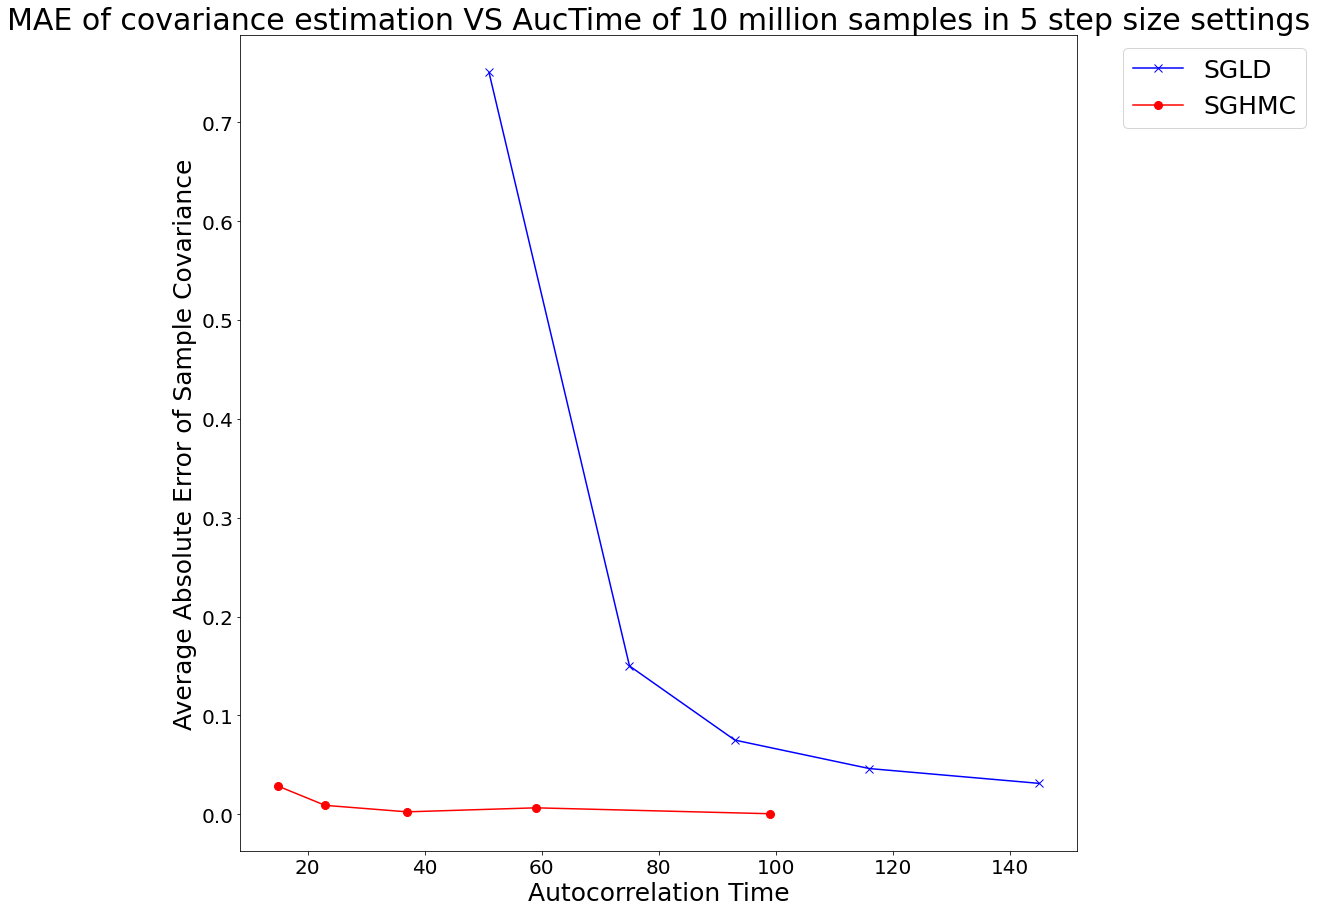

In [28]:
## draw the Figure 3a
plt.title('MAE of covariance estimation VS AucTime of 10 million samples in 5 step size settings', fontsize=30) # title of the fig
plt.rcParams["figure.figsize"] = [15, 15] # the image size: width, length
plt.xlabel('Autocorrelation Time', fontsize=25)  # the x axis label name
plt.ylabel('Average Absolute Error of Sample Covariance', fontsize=25)  # the x axis label name
plt.tick_params(axis='x', labelsize=20) # the x axis label size
plt.tick_params(axis='y', labelsize=20) # the y axis label size

plt.plot(SGLDauc,SGLDCovErr,'b-x',markersize=8,label='SGLD')
plt.plot(SGHMCauc,SGHMCCovErr,'r-o',markersize=8,label='SGHMC')

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize=25)
plt.savefig('./Fig3/Fig3_MAEvsAucTime.jpg', bbox_inches='tight')
plt.show()